In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### load MNIST data

In [3]:
from scipy.io import loadmat
train_mnist = loadmat('mnist_train.mat')

In [4]:
data = train_mnist['train_X']
data.shape

(60000, 784)

In [5]:
labels = train_mnist['train_labels']
labels.shape

(60000, 1)

downsample data to 100000

In [6]:
idx = np.random.randint(60000, size=10000)

In [7]:
data = data[idx, :]

In [8]:
labels = labels[idx]

In [9]:
labels = labels[:,0].tolist()

### regular t-SNE on training data

In [10]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=30.0, early_exaggeration=4.0, \
             learning_rate=1000.0, n_iter=1000, n_iter_without_progress=30, \
             min_grad_norm=1e-07, metric='euclidean', init='random', verbose=1, \
             random_state=None, method='barnes_hut', angle=0.5)
data_embeding = model.fit_transform(data) 

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.076032
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.393219
[t-SNE] Error after 300 iterations: 1.393219


In [11]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # requires version >= 1.9.0
from plotly.graph_objs import *
init_notebook_mode(connected=True)

2.0.8


In [12]:
import colorlover as cl

In [13]:
colors = cl.scales['11']['qual']['Paired']

In [14]:
scatter_color = [colors[x] for x in labels]

In [29]:
points = Scatter(
    x=data_embeding[:,0],
    y=data_embeding[:,1],
    text = labels[:],
    mode='markers',
    marker=dict(
        size = 3,
        color = scatter_color
    )
) 

layout = Layout(
        width=750,
        height=750,
        margin=Margin(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
        xaxis=dict(
            zeroline=False
        ),
        yaxis=dict(
            zeroline=False
        ),
        legend=dict(orientation="h"),
        showlegend=True,
        hovermode ='closest',
    )

fig = Figure(data=[points], layout=layout)
iplot(fig, show_link=False)

### construct the neural network

In [16]:
D_in, fc1, fc2, fc3, D_out = 784, 500, 500, 2000, 2

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, fc1), torch.nn.ReLU(),
    torch.nn.Linear(fc1, fc2), torch.nn.ReLU(),
    torch.nn.Linear(fc2, fc3), torch.nn.ReLU(),
    torch.nn.Linear(fc3, D_out)
)

### prepare mini-batch data

In [17]:
class MyMNISTDataset(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.x.shape[0]
    

from torch.utils.data import DataLoader


dataset = MyMNISTDataset(data, data_embeding)
data_loader = DataLoader(dataset, batch_size=2000, num_workers=0, shuffle=False)

### train the network

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss(size_average=True)

for epoch in range(100):  
    for i, batch in enumerate(data_loader):
        x, y = batch
        x_var = autograd.Variable(x.float())
        y_var = autograd.Variable(y.float())
        y_pred = model(x_var)
        loss = loss_fn(y_pred, y_var) 
          
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch {}: loss {}'.format(epoch, loss.data[0]))

epoch 0: loss 14.117144584655762
epoch 1: loss 10.681282043457031
epoch 2: loss 9.540135383605957
epoch 3: loss 8.064517974853516
epoch 4: loss 6.4513959884643555
epoch 5: loss 5.434328079223633
epoch 6: loss 4.709479331970215
epoch 7: loss 4.046679973602295
epoch 8: loss 3.4482970237731934
epoch 9: loss 3.092731237411499
epoch 10: loss 2.721693277359009
epoch 11: loss 2.4514734745025635
epoch 12: loss 2.178542375564575
epoch 13: loss 1.9815704822540283
epoch 14: loss 1.800362229347229
epoch 15: loss 1.6471421718597412
epoch 16: loss 1.5135091543197632
epoch 17: loss 1.39528226852417
epoch 18: loss 1.283326268196106
epoch 19: loss 1.1798882484436035
epoch 20: loss 1.0872292518615723
epoch 21: loss 0.9997314214706421
epoch 22: loss 0.9176080822944641
epoch 23: loss 0.8516470789909363
epoch 24: loss 0.7669072151184082
epoch 25: loss 0.8102218508720398
epoch 26: loss 0.6478508114814758
epoch 27: loss 0.8993154168128967
epoch 28: loss 0.6514536142349243
epoch 29: loss 0.5607995390892029
ep

### predict the data and visualization

In [19]:
tst_data = train_mnist['train_X']
tst_idx = np.random.randint(60000, size=10000)
tst_data = tst_data[tst_idx, :]

tst_labels = train_mnist['train_labels']
tst_labels = tst_labels[tst_idx, 0].tolist()

tst_x_var = autograd.Variable(torch.Tensor(tst_data))

In [20]:
tst_y_pred = model(tst_x_var)

In [21]:
tst_data_embed = tst_y_pred.data.numpy()

In [22]:
scatter_color = [colors[x] for x in tst_labels]

In [23]:
tst_points = Scatter(
    x=tst_data_embed[:,0],
    y=tst_data_embed[:,1],
    mode='markers',
    marker=dict(
        size = 3,
        color = scatter_color
    )
) 

iplot({
    'data': [tst_points],
    'layout': layout
    },
    show_link=False)

### visulization the network

In [24]:
x_tnsr = torch.Tensor(data)
type(x_tnsr)

torch.FloatTensor

In [25]:
x = autograd.Variable(x_tnsr)
type(x)

torch.autograd.variable.Variable

In [26]:
y_pred = model(x)

In [27]:
from graphviz import Digraph
import torch
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    pass
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

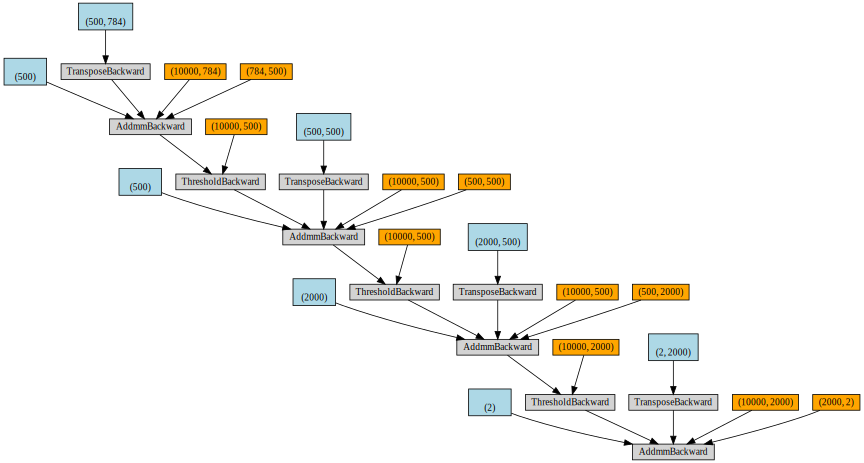

In [28]:
make_dot(y_pred)